In [2]:
import gensim.downloader as api
wv=api.load('word2vec-google-news-300')

In [3]:
wv.similarity(w1='great',w2='good')

0.729151

In [4]:
wv_great=wv['great']
wv_good=wv['good']

In [5]:
wv_great.shape

(300,)

wv_great

In [12]:
import pandas as pd

In [13]:
df=pd.read_csv('Fake_Real_Data.csv')

In [14]:
df.shape

(9900, 2)

In [15]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [17]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [24]:
df['label_num']=df.label.map({
    "Fake":0,"Real":1
})

In [25]:
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [26]:
import spacy as sp
nlp=sp.load("en_core_web_lg")

In [35]:
def preprocess_and_vectorize(text):
    doc=nlp(text)
    
    filtered_tokens=[]
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [37]:
preprocess_and_vectorize("Don't worry if you don't understand").shape

(300,)

In [ ]:
# we find mean of these vectors 
vector1-->[]
vector2-->[]

mean -->[]

In [30]:
wv.get_mean_vector(['worry','understand'],pre_normalize=False)[:3]

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

In [33]:
v1=wv['worry']
v2=wv['understand']
import numpy as np
np.mean([v1,v2],axis=0)[:3]

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

#### Both above are same vectors

In [38]:
df['vector']=df['Text'].apply(lambda text:preprocess_and_vectorize(text))

In [39]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.008657642, 0.019024342, -0.011917442, 0.032..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.010864096, 0.007960429, 0.0011915653, 0.014..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.018134918, 0.0062743523, -0.005872244, 0.03..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.01255197, 0.012613623, 5.9780963e-05, 0.021..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.0019059887, 0.011889367, 0.0035395357, 0.0..."


In [44]:
from sklearn.model_selection import train_test_split as tts

X_train,X_test,y_train,y_test=tts(df.vector.values,df.label_num,test_size=0.20,random_state=2022,stratify=df.label_num)

### Reshaping the X_train and X_Test so as fit for models

In [45]:
print("Shape of X_Train before reshaping: ",X_train.shape)
print("Shape of X_Test before reshaping: ",X_test.shape)

X_train_2d=np.stack(X_train)
X_test_2d=np.stack(X_test)


print("Shape of X_Train after reshaping: ",X_train_2d.shape)
print("Shape of X_Test after reshaping: ",X_test_2d.shape)

Shape of X_Train before reshaping:  (7920,)
Shape of X_Test before reshaping:  (1980,)
Shape of X_Train after reshaping:  (7920, 300)
Shape of X_Test after reshaping:  (1980, 300)


#### Train Machine Learning Model

I tried Random Forest,decision tree , naive bayes etc classifier as well but gradient boosting gave the best performance of all

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf=GradientBoostingClassifier()

clf.fit(X_train_2d,y_train)

y_pred=clf.predict(X_test_2d)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



In [52]:
text_news=[
    '''We are investigating a shooting incident with multiple victims that occurred at Old Settlers Park tonight,” Rick White, with the Round Rock Police Department, told CNN. “We don’t have a suspect in custody but we’re searching for suspects''',
    "The government should publish advice for its departments on engaging with young people, including on TikTok, a group of MPs has said.The culture, media and sport committee has been looking into countering disinformation online.",
    "A new Russian school textbook has been produced that distorts the history of the war against Ukraine and encourages students to join the army"
]

test_news_vectors=[preprocess_and_vectorize(n) for n in text_news]
clf.predict(test_news_vectors)

array([1, 1, 1], dtype=int64)

### Confusion MAttrix

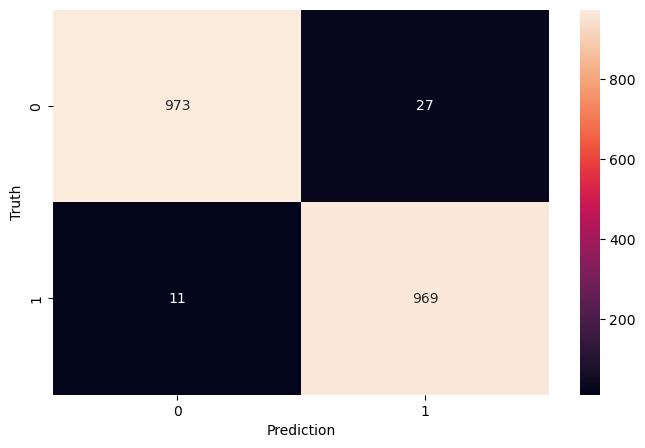

In [55]:
from sklearn.metrics import confusion_matrix as c_m
cm=c_m(y_test,y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show() 